# Conditional GAN

## Introduction to Normal GANs 
![](./GAN_Demo.png)

> A GAN contains a generator and a discriminator. A discriminator can be like a Convolutional Neural Network that tries to determine whether an image is real or fake. While doing so, the discriminator leaves behind a gradient that the generator can use to improve its own output. The generator competes with the discriminator and generates images. However when exploring simple GANs and looking at the output I noticed that the images was difficult to interpret or it seemed like the images was a little bit of an airplane and a little bit of a car.



## How CGAN or CDCGAN(Conditional Deep Convolutional GAN) can enhance output interpretability

![](./CGAN_Demo.png)

> CGAN is different from GAN where not only the pixels of real images are passed into the model , labels of each image is also passed in . As such the generator model generates images with a specific label
CDCGAN contains additional Convolutional transpose layers in the generator and Convolutional layers in the Discriminator  

image by Saul Dobilas https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8

# Conditional GANS
> The Generator and discriminator of the CGANs are conditioned on additional information such as class labels.

| Class Number      | Name |
| ----------- | ----------- |
| 0   | Airplane      |
| 1   | Automobile    |
| 2   | Bird      |
| 3   | Cat    |
| 4   | Deer      |
| 5   | Dog   |
| 6   | Frog      |
| 7   | Horse    |
| 8   | Ship      |
| 9   | Truck    |



## All required imports

In [2]:
# DL modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
import keras.backend as K
from tensorflow.keras import initializers
! pip install tensorflow_addons
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.optimizers import Adam

# relevent libraries 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## matplotlib stylings
plt.rcParams['figure.figsize'] = 12, 8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


## Constants and hyperparams

In [3]:
batch_size = 128
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 128

In [4]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])


170498071/170498071 [==============================] - 3s 0us/step


# Conditional GAN takes in labels as the datasets 


In [5]:
# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 127.5 - 1
all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


### Conditioning the CGAN to be able to produce class images
> We try to add the latent dimensions and the number of classes in the image so that we can condition the generator to be able to generate images based on classes. This is also true for the discriminator such that the discriminator that distinguish whether an image is fake and also the class of it.

In [6]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 13


In [7]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1 activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(8 * 8 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (8, 8), padding="same", activation="tanh"),
    ],
    name="generator",
)

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        7552      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8832)              1227648   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8832)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                               

In [10]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        


    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [11]:
class CONDGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=100, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        # Create a figure with 10 rows and 10 columns

            
            
        if (epoch % 50 == 1):
            fig, axes = plt.subplots(10,10, figsize=(10, 10))
            axes = axes.ravel()
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                axes[i].imshow(img)
                axes[i].axis("off")
            title = "Epoch " + str(epoch)
            plt.suptitle(title)
            if (epoch % 250 == 1):
                path = "./Image/CGAN/generated_img_" + str(epoch) + '_model1'
                plt.savefig(path,dpi=300)
            plt.show()

        
        
            

Epoch 1/300
469/469 [==============================] - 9s 16ms/step - g_loss: 1.2933 - d_loss: 0.6396
Epoch 2/300
467/469 [============================>.] - ETA: 0s - g_loss: 1.9338 - d_loss: 0.4284

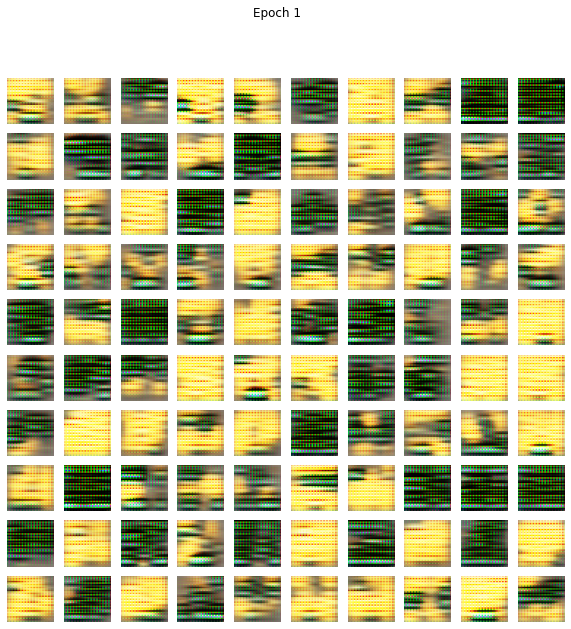

469/469 [==============================] - 11s 24ms/step - g_loss: 1.9330 - d_loss: 0.4286
Epoch 3/300
469/469 [==============================] - 7s 15ms/step - g_loss: 1.1550 - d_loss: 0.6556
Epoch 4/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.9193 - d_loss: 0.7750
Epoch 5/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.8249 - d_loss: 0.6810
Epoch 6/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.8926 - d_loss: 0.7134
Epoch 7/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.6987 - d_loss: 0.7198
Epoch 8/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.8421 - d_loss: 0.6714
Epoch 9/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.7831 - d_loss: 0.7368
Epoch 10/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.7918 - d_loss: 0.6791
Epoch 11/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7569 - d_lo

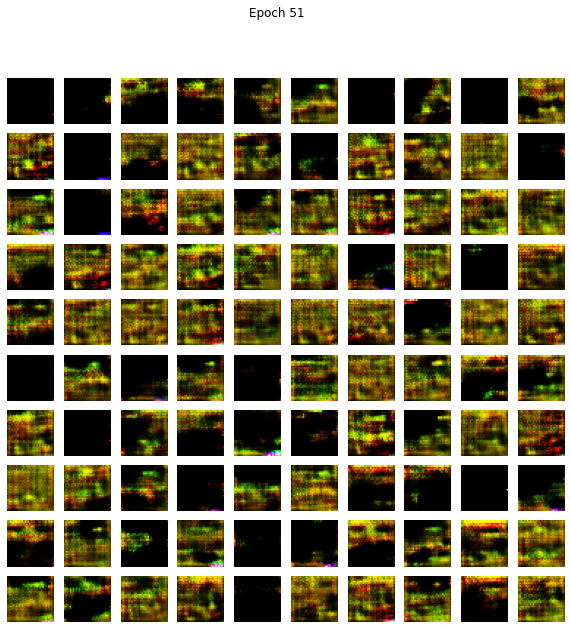

469/469 [==============================] - 10s 21ms/step - g_loss: 6.2137 - d_loss: 0.0922
Epoch 53/300
469/469 [==============================] - 7s 16ms/step - g_loss: 4.0436 - d_loss: 0.5975
Epoch 54/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.9323 - d_loss: 0.7389
Epoch 55/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.9907 - d_loss: 0.7516
Epoch 56/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.8469 - d_loss: 0.8423
Epoch 57/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.7322 - d_loss: 0.8196
Epoch 58/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.7634 - d_loss: 0.7419
Epoch 59/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.8058 - d_loss: 0.7418
Epoch 60/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.7117 - d_loss: 0.7521
Epoch 61/300
469/469 [==============================] - 7s 15ms/step - g_loss: 0.7185

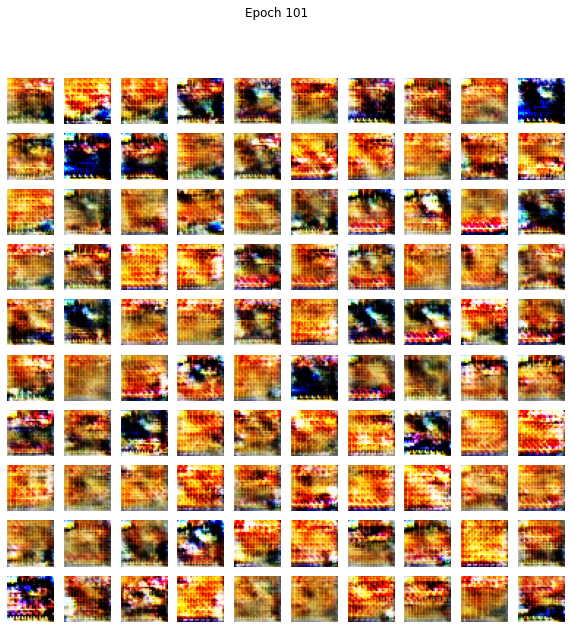

469/469 [==============================] - 10s 21ms/step - g_loss: 0.6765 - d_loss: 0.7147
Epoch 103/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6918 - d_loss: 0.7082
Epoch 104/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6927 - d_loss: 0.7078
Epoch 105/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7030 - d_loss: 0.7024
Epoch 106/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6943 - d_loss: 0.7027
Epoch 107/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6977 - d_loss: 0.7017
Epoch 108/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6951 - d_loss: 0.6997
Epoch 109/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7121 - d_loss: 0.7004
Epoch 110/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6871 - d_loss: 0.7210
Epoch 111/300
469/469 [==============================] - 7s 16ms/step - g_los

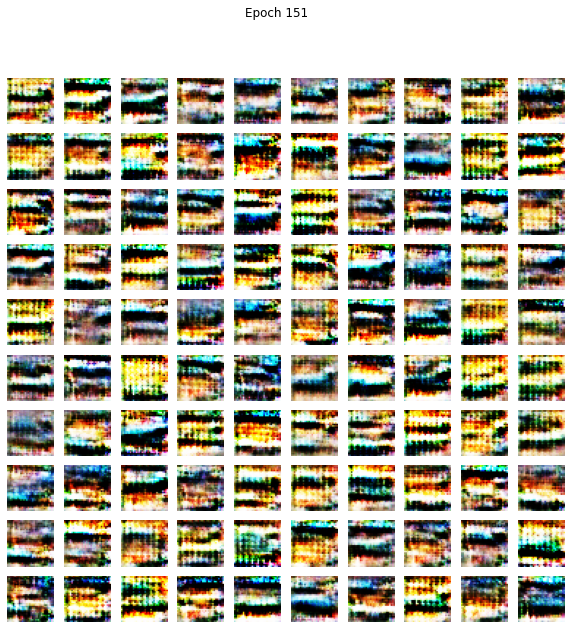

469/469 [==============================] - 10s 21ms/step - g_loss: 0.6898 - d_loss: 0.6995
Epoch 153/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7792 - d_loss: 0.6833
Epoch 154/300
469/469 [==============================] - 7s 16ms/step - g_loss: 1.3355 - d_loss: 0.5975
Epoch 155/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6878 - d_loss: 0.7111
Epoch 156/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6937 - d_loss: 0.6987
Epoch 157/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7080 - d_loss: 0.6917
Epoch 158/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6885 - d_loss: 0.6968
Epoch 159/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6983 - d_loss: 0.6935
Epoch 160/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7242 - d_loss: 0.7001
Epoch 161/300
469/469 [==============================] - 7s 16ms/step - g_los

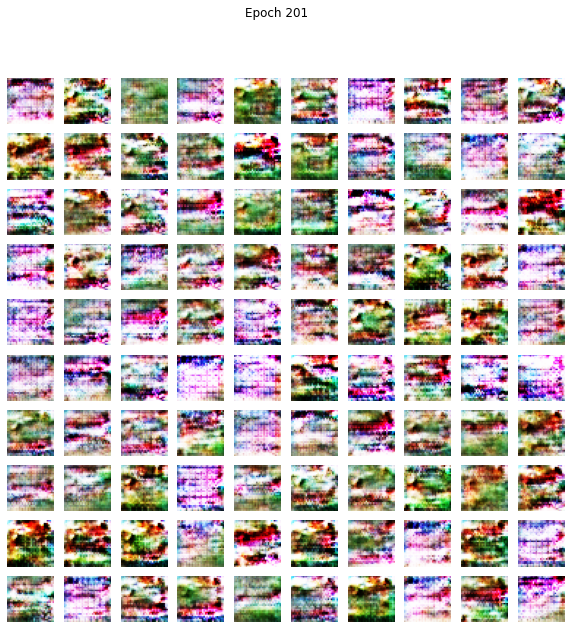

469/469 [==============================] - 10s 21ms/step - g_loss: 0.7023 - d_loss: 0.7012
Epoch 203/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6899 - d_loss: 0.6991
Epoch 204/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6971 - d_loss: 0.7048
Epoch 205/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7141 - d_loss: 0.7007
Epoch 206/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6987 - d_loss: 0.6993
Epoch 207/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6878 - d_loss: 0.7086
Epoch 208/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7490 - d_loss: 0.6979
Epoch 209/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7186 - d_loss: 0.7008
Epoch 210/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6846 - d_loss: 0.7120
Epoch 211/300
469/469 [==============================] - 7s 16ms/step - g_los

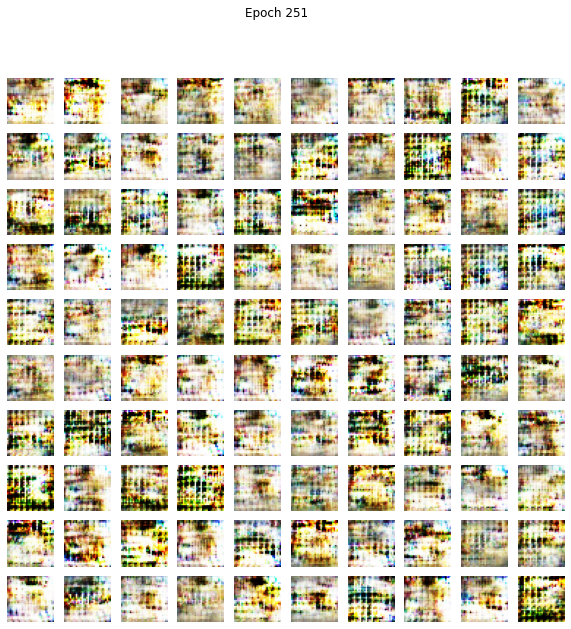

469/469 [==============================] - 11s 24ms/step - g_loss: 0.6917 - d_loss: 0.7019
Epoch 253/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6894 - d_loss: 0.6991
Epoch 254/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6951 - d_loss: 0.7089
Epoch 255/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6960 - d_loss: 0.6958
Epoch 256/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7045 - d_loss: 0.6964
Epoch 257/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.7702 - d_loss: 0.7011
Epoch 258/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6966 - d_loss: 0.7000
Epoch 259/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6891 - d_loss: 0.6967
Epoch 260/300
469/469 [==============================] - 7s 16ms/step - g_loss: 0.6953 - d_loss: 0.6959
Epoch 261/300
469/469 [==============================] - 7s 16ms/step - g_los

In [13]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=128
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=300, callbacks=[CONDGANMonitor(num_img=100, latent_dim=138)])

In [14]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 2  # @param {type:"slider", min:0, max:9, step:1}
end_class = 8  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 [==============================] - 0s 137ms/step


In [16]:
pip install embed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for embed: filename=embed-0.1.0-py3-none-any.whl size=1008 sha256=12392220a8f74c33c11708aceed15f75fb19a2b6cc02fb547dbe3675626dd166
  Stored in directory: /root/.cache/pip/wheels/c8/35/f4/81e4b165ff72cc893eb3b23dd622543ea2f43a77b59911d57f
Successfully built embed


In [24]:
tf.keras.models.save_model(generator , "./generator_cgan1.h5")

In [25]:
tf.keras.models.save_model(discriminator , "./discriminator_cgan1.h5")

In [26]:
gen = tf.keras.models.load_model("./generator_cgan1.h5")
gen.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8832)              1227648   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8832)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                               

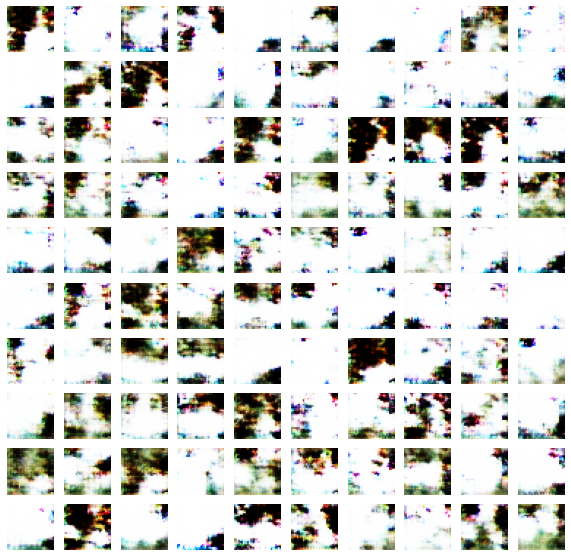

In [29]:
#  generate 100 images and plot it in a 10x10 grid

random_latent_vectors = tf.random.normal(shape=(100, 138))
generated_images = gen(random_latent_vectors)
generated_images = (generated_images + 1) * (255/2)
generated_images.numpy()
# Create a figure with 10 rows and 10 columns
fig, axes = plt.subplots(10,10, figsize=(10, 10))
axes = axes.ravel()
for i in range(100):
    img = keras.preprocessing.image.array_to_img(generated_images[i])
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()
